## Lesson 2 

Lesson 2 demonstrates how to visualise outputs from the simulation we ran in lesson 1.



### Libraries 
First we load some libraries we are going to use for plotting. 

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm

#### Make some colours for plotting

In [2]:
dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

### Load the FATES run

In [18]:
fates = '/pscratch/sd/j/jneedham/elm_runs/fates-tute-runs/bci/fates-tutorial-bci-inventory_init.E93ab10c892-Fe28ac5af.2024-02-16/run/fates-tutorial-bci-inventory_init.E93ab10c892-Fe28ac5af.2024-02-16.elm.h0.sofar.nc'
fates = xr.open_dataset(fates,  decode_times=False)

nyears = int(len(fates.variables['time'])/12)
print(nyears)
time = fates.variables['time'] / 365.

tave_start = (nyears-10)
tave_stop = nyears

cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)
patch_age_bins = fates.variables['fates_levage'][:]

100


### Biomass and number of plants through time

We start by just plotting the total AGB and number of plants through time. The history variable FATES_NPLANT_SZPF is output along a size and pft dimension. Here we just sum over that dimension. In lesson x we will untangle multiplexed dimensions to plot variables by pft or size or both. 

''

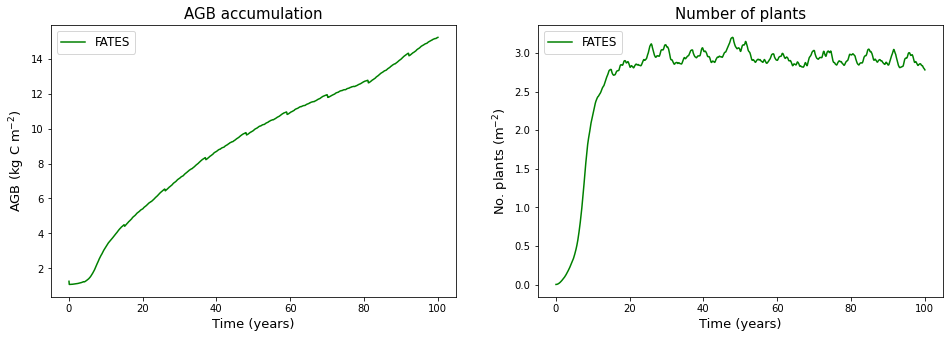

In [6]:
fig1, ((f1ax0, f1ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(16,5))

f1ax0.plot(time, fates.FATES_VEGC_ABOVEGROUND, color='green', label = 'FATES')
f1ax0.set_title(r'AGB accumulation', fontsize = 15)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 13)
f1ax0.set_xlabel(r'Time (years)', fontsize = 13) 
f1ax0.legend(prop={'size':12})

f1ax1.plot(time, fates.FATES_NPLANT_SZPF.sum(dim='fates_levscpf'), color='green', label = 'FATES')
f1ax1.set_title(r'Number of plants', fontsize = 15)
f1ax1.set_ylabel(r'No. plants (m$^{-2}$)', fontsize = 13)
f1ax1.set_xlabel(r'Time (years)', fontsize = 13)    
f1ax1.legend(prop={'size':12})
;

Now we can plot both variables by size through time as a heat plot. 

Text(0, 0.5, 'Cohort Size (cm)')

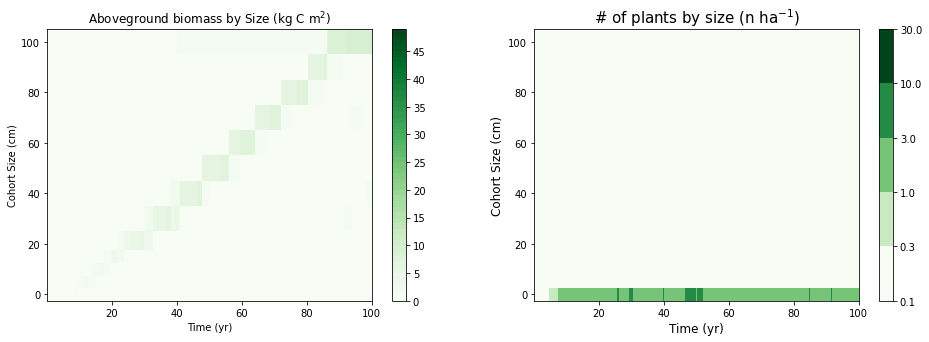

In [7]:
# population numbers as a function of cohort size
NPLANT_CANOPY_SZ = fates.FATES_NPLANT_CANOPY_SZ
NPLANT_UNDERSTORY_SZ = fates.FATES_NPLANT_USTORY_SZ

VEGC_ABOVEGROUND_SZ = fates.FATES_VEGC_ABOVEGROUND_SZ

fig2, ((f2ax0, f2ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(16,5))

## set up the first plot: evolution of basal area of plants of a given size
levels = np.arange(0.,50, 1)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f2ax0.pcolormesh(time, cohort_size_bins, VEGC_ABOVEGROUND_SZ[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax0)
f2ax0.set_title(r'Aboveground biomass by Size (kg C m$^2$)')
f2ax0.set_xlabel('Time (yr)')
f2ax0.set_ylabel('Cohort Size (cm)')

levels = np.array([0.1,0.3,1.,3.,10.,30.]) # do a pseudo-log scale here
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f2ax1.pcolormesh(time, cohort_size_bins, (NPLANT_CANOPY_SZ + NPLANT_UNDERSTORY_SZ)[:,:,0].transpose(),
                      cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax1)
f2ax1.set_title(r'# of plants by size (n ha$^{-1}$)', fontsize=15)
f2ax1.set_xlabel('Time (yr)', fontsize=12)
f2ax1.set_ylabel('Cohort Size (cm)', fontsize=12)



#### Size distributions

To plot the size distribution we will average over the last ten years of the simulation. 
We divide by size bin width so that we are plotting number of plants per cm. 

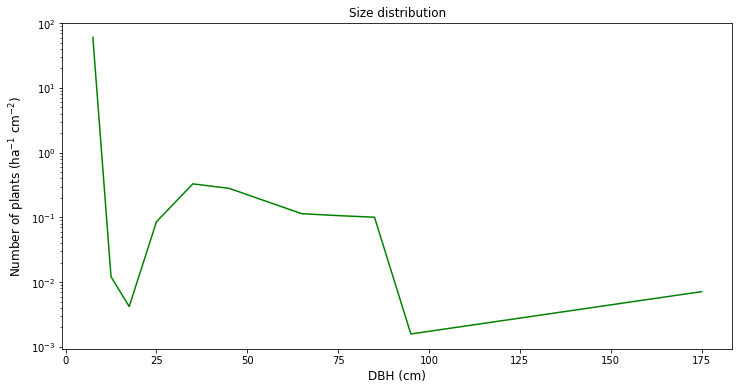

In [20]:
# size bins are LOWER bounds. Remove the fist bin - but add an extra bin to catch trees over last bin edge
cohort_size_bins_ex = np.append(cohort_size_bins[1:], 250)
fates_sizebin_mids = (cohort_size_bins_ex[0:-1] + cohort_size_bins_ex[1:])/2
fates_sizebin_widths = cohort_size_bins_ex[1:] - cohort_size_bins_ex[:-1]

nplant = fates.FATES_NPLANT_SZ.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 10000 # convert to plants per ha (from m-2)
fates_sd = np.squeeze(nplant[1:,])/fates_sizebin_widths


fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

f2ax0.plot(fates_sizebin_mids, fates_sd, color='green', label = 'FATES')    
    
f2ax0.set_title(r'Size distribution', fontsize = 12)
f2ax0.set_ylabel(r'Number of plants (ha$^{-1}$ cm$^{-2}$)', fontsize = 12)
f2ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
       
f2ax0.set_yscale('log')
f2ax0.set_xscale('log')

#### GPP and NPP

In [ ]:
fig1, ((f1ax0, f1ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(16,5))

# convert from per second to per year by multiplying by 365 * 86400
f1ax0.plot(time, fates.FATES_GPP * 365 * 86400, color='green')
f1ax0.set_title(r'GPP', fontsize = 15)
f1ax0.set_ylabel(r'GPP(kg C m$^{-2}$ s$^{-1}$)', fontsize = 13)
f1ax0.set_xlabel(r'Time (years)', fontsize = 13) 

f1ax1.plot(time, fates.FATES_NPP * 365 * 86400, color='green')
f1ax1.set_title(r'NPP', fontsize = 15)
f1ax1.set_ylabel(r'NPP(kg C m$^{-2}$ s$^{-1}$)', fontsize = 13)
f1ax1.set_xlabel(r'Time (years)', fontsize = 13)    

;

#### Growth and mortality

Growth and mortality are output as the absolute dbh increment in cm and the number of plants that died. To convert them to growth we need to divide by the number of plants. 

In [ ]:
# population numbers as a function of cohort size
NPLANT_CANOPY_SZ = fates.FATES_NPLANT_CANOPY_S
NPLANT_UNDERSTORY_SZ = fates.FATES_NPLANT_USTORY_SZ

DDBH_CANOPY_SZ = fates.FATES_DDBH_CANOPY_SZ
DDBH_UNDERSTORY_SZ = fates.FATES_DDBH_USTORY_SZ

MORT_CANOPY_SZ = fates.FATES_MORTALITY_CANOPY_SZ
MORT_UNDERSTORY_SZ = fates.FATES_MORTALITY_USTORY_SZ

# set up the page
fig3, ((f3ax0, f3ax1), (f3ax2, f3ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

## set up the first plot: growth rate (in diameter increment) in the canopy
levels = np.arange(0.,1.5, 0.05)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax0.pcolormesh(time, cohort_size_bins, (DDBH_CANOPY_SZ / NPLANT_CANOPY_SZ)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax0)
f3ax0.set_title(r'Growth rate of canopy plants (cm DBH yr$^{-1}$)')
f3ax0.set_xlabel('Time (yr)')
f3ax0.set_ylabel('Cohort Size (cm)')

## set up the second plot: growth rate in the understory, units as above
levels = np.arange(0.,0.15, 0.005)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax1.pcolormesh(time, cohort_size_bins, (DDBH_UNDERSTORY_SZ / NPLANT_UNDERSTORY_SZ)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax1)
f3ax1.set_title(r'Growth rate of understory plants (cm yr$^{-1}$)')
f3ax1.set_xlabel('Time (yr)')
f3ax1.set_ylabel('Cohort Size (cm)')

## set up the third plot: mortality rate in the canopy, in units of fraction of trees per year of a given size class and canopy position
levels = np.arange(0.,0.1, 0.01)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax2.pcolormesh(time, cohort_size_bins, (MORT_CANOPY_SZ / NPLANT_CANOPY_SZ)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax2)
f3ax2.set_title(r'Mortality rate of canopy plants (yr$^{-1}$)')
f3ax2.set_xlabel('Time (yr)')
f3ax2.set_ylabel('Cohort Size (cm)')

## set up the fourth plot: mortality rate in the understory, units as above
levels = np.arange(0.,1.0, 0.1)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax3.pcolormesh(time, cohort_size_bins, (MORT_UNDERSTORY_SZ / NPLANT_UNDERSTORY_SZ)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax3)
f3ax3.set_title(r'Mortality rate of understory plants (yr$^{-1}$)')
f3ax3.set_xlabel('Time (yr)')
f3ax3.set_ylabel('Cohort Size (cm)')

fig3.tight_layout()